In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [35]:
colormap = {
    "incremental": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "spacesaving": "C4",
    "cms_min": "C5",
    "approx_histogram": "C6",
    "random": "C7"
}
markers = {
    "incremental": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    "spacesaving": "D",
    "cms_min": "o",
    "approx_histogram": "<",
    "random": ">"
}
alg_display_name = {
    "incremental": "Greedy",
    "truncation": "Truncation",
    "pps": "PPS Sampling",
    "random_sample": "Simple Sampling",
    "spacesaving": "Space Saving Sketch",
    "cms_min": "CountMinSketch"
}

In [37]:
def count_to_vec(x_counts, max_val):
    counts = np.zeros(max_val)
    for i in range(max_val):
        counts[i] = x_counts.get(i,0)
    return counts

# Multi Grain

In [95]:
def calc_day(result_list, grain):
    start_idx = 1*grain/2
    end_idx = 2*grain/2
    method_results = {
        "topvalue": 0,
        "random_sample": 0,
        "truncation": 0,
        "pps": 0,
        "incremental": 0,
        "spacesaving": 0,
        "cms_min": 0,
    }
    for cur_result in result_list:
        cur_idx = cur_result["seg_idx"]
        cur_method = cur_result["method"]
        cur_counts = cur_result["counts"]
        if cur_idx >= start_idx and cur_idx < end_idx:
            method_results[cur_method] += count_to_vec(cur_counts, 200)
    return method_results

In [102]:
grains = [8, 32, 128, 512, 2048]
grain_results = []
for cur_grain in grains:
    with open("../output/grain_caida_{}.out".format(cur_grain)) as f:
        results = ast.literal_eval(f.read())
        grain_results.append(results)

In [111]:
grains = [8, 32, 128, 512, 2048]
grain_results = []
for cur_grain in grains:
    with open("../output/grain_{}.out".format(cur_grain)) as f:
        results = ast.literal_eval(f.read())
        grain_results.append(results)

In [108]:
def plot_grain_results(grains, grain_results):
    method_results = {
        "random_sample": [],
        "truncation": [],
        "pps": [],
        "incremental": [],
        "spacesaving": [],
        "cms_min": [],
    }

    for grain_idx in range(len(grains)):
        grain = grains[grain_idx]
        day_counts = calc_day(grain_results[grain_idx], grain)
        for cur_method in method_results.keys():
            cur_errors = day_counts[cur_method] - day_counts["topvalue"]
            rmse = np.sqrt(np.mean(cur_errors**2))
            method_results[cur_method].append(rmse)
    
    plt.figure()
    for method in ["incremental", "pps", "cms_min", "random_sample", "truncation"]:
        plt.loglog(
            grains,
            method_results[method],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
        )
        plt.ylim(1,10000)
        plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
        plt.xlabel("# Segments")
        plt.ylabel("Average Count Error")
        plt.tight_layout()
    return method_results


{'random_sample': [286.5829729142677,
  260.2865907281755,
  258.3487144761599,
  248.17497441282165,
  253.40378844839714],
 'truncation': [1.5280706789936125,
  17.38634521686487,
  163.20081188523542,
  543.1558109787651,
  944.5950878551084],
 'pps': [4.939904950351038,
  48.52455729743929,
  155.81954896149236,
  213.15482562109082,
  264.24694038285605],
 'incremental': [1.7930421077041108,
  12.96167427456808,
  20.506950041388407,
  19.957705278914208,
  21.586222457854916],
 'spacesaving': [8.095369046559892,
  58.755084886331325,
  193.40460180667884,
  237.75933209865812,
  286.5319964681083],
 'cms_min': [6.254598308444756,
  65.67446231222605,
  644.2072414991933,
  4435.653625453638,
  22526.705078195522]}

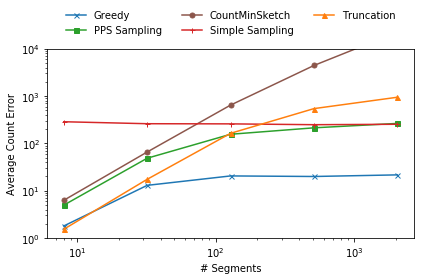

In [109]:
plot_grain_results(grains, grain_results)

{'random_sample': [123.66398020442331,
  102.31549247303656,
  121.72222475784773,
  114.67789673690393,
  99.61997791607865],
 'truncation': [0.0,
  1.4866068747318506,
  37.69549044647118,
  142.54839529086252,
  354.92786591080727],
 'pps': [3.866129361523834,
  32.02210657939411,
  63.72001041020457,
  95.14523419041177,
  130.92027602120842],
 'incremental': [0.0,
  2.092844953645635,
  3.9293765408777,
  5.319304465811296,
  6.618912297349165],
 'spacesaving': [5.972018084366456,
  35.502675955482566,
  61.81241784625481,
  82.63507124701957,
  145.8301409174386],
 'cms_min': [1.969771560359221,
  37.18205212195798,
  404.908372351079,
  2389.796035229785,
  12148.445447875214]}

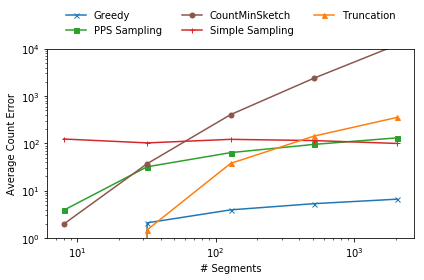

In [112]:
plot_grain_results(grains, grain_results)

# Single Line

In [36]:
with open("../output/linear_bench.out") as f:
    results = ast.literal_eval(f.read())

In [38]:
seg_counts = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "spacesaving": [],
    "cms_min": [],
    "cms_mean": [],
}
cum_counts = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "spacesaving": [],
    "cms_min": [],
    "cms_mean": [],
}
tot_counts = {
    "topvalue": 0,
    "random_sample": 0,
    "truncation": 0,
    "pps": 0,
    "incremental": 0,
    "spacesaving": 0,
    "cms_min": 0,
    "cms_mean": 0,
}
for cur_result in results:
    method_name = cur_result["method"]
    cur_vec = count_to_vec(cur_result["counts"], 100)
    seg_counts[method_name].append(cur_vec)
    tot_counts[method_name] += cur_vec
    cum_counts[method_name].append(np.copy(tot_counts[method_name]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


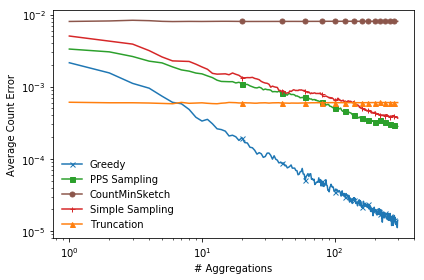

In [39]:
errors_over_time = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "cms_min": []
}
n_segs = len(cum_counts["topvalue"])
start_idx = n_segs//4
# start_idx = 0
for method in ["incremental", "pps", "cms_min", "random_sample", "truncation"]:
    for idx in range(start_idx, n_segs):
        cur_vec = cum_counts[method][idx] - cum_counts[method][start_idx]
        top_vec = cum_counts["topvalue"][idx] - cum_counts["topvalue"][start_idx]
        tot_counts = (idx-start_idx)*1000
        cur_error = np.mean(np.abs(cur_vec-top_vec)/tot_counts)
        errors_over_time[method].append(cur_error)
    errors_over_time[method] = np.array(errors_over_time[method])
#     print("{}:{}".format(
#         method,
#         np.mean(np.abs(tot_counts[method]-tot_counts["topvalue"]))
#     ))
    plt.loglog(
        errors_over_time[method],
        label=alg_display_name[method],
        marker=markers[method],
        color=colormap[method],
             markevery=20,
        markersize=5,
    )
#     plt.ylim(1,10)
plt.legend(frameon=False)
plt.xlabel("# Aggregations")
plt.ylabel("Average Count Error")
plt.tight_layout()
# plt.savefig("linear_balance.pdf")

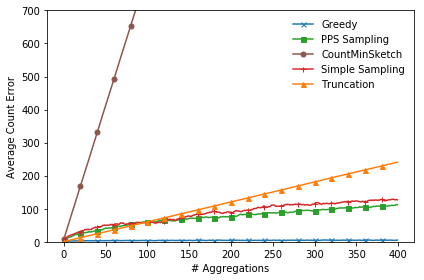

In [40]:
errors_over_time = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "cms_min": []
}
for method in ["incremental", "pps", "cms_min", "random_sample", "truncation"]:
    for idx,cur_vec in enumerate(cum_counts[method]):
        cur_error = np.mean(np.abs(cur_vec-cum_counts["topvalue"][idx]))
        errors_over_time[method].append(cur_error)
    errors_over_time[method] = np.array(errors_over_time[method])
#     print("{}:{}".format(
#         method,
#         np.mean(np.abs(tot_counts[method]-tot_counts["topvalue"]))
#     ))
    plt.plot(errors_over_time[method],
        label=alg_display_name[method],
        marker=markers[method],
        color=colormap[method],
             markevery=20,
        markersize=5,
    )
    plt.ylim(0,700)
plt.legend(frameon=False)
plt.xlabel("# Aggregations")
plt.ylabel("Average Count Error")
plt.tight_layout()
plt.savefig("linear_balance.pdf")

In [79]:
for method in ["incremental", "pps", "spacesaving", "random_sample", "truncation"]:
    print("{}:{}".format(
        method,
        np.max(np.abs(tot_counts[method]-tot_counts["topvalue"]))
    ))

incremental:19.0
pps:535.0
spacesaving:748.0
random_sample:748.0
truncation:498.0
